### Import python files from another directory
In order to reuse code written in .py files you need to import them. <br/>
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [1]:
import sys
sys.path.append("../../ex02/template") # This goes up twice in the directories tree (hence in labs)
                                       # then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [2]:
import grid_search as gs
import gradient_descent as gd
import costs

As you can see we are now able to call functions from the grid_search.py file.

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [4]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    prod = tx.T.dot(tx)
    c = np.linalg.cond(prod)
    print('Condition number = {}'.format(c))
    w = np.linalg.inv(prod).dot(tx.T).dot(y)
    y_pred = tx.dot(w)
    train_mse = ((y - y_pred) ** 2).sum() / len(y_pred)
    return w, train_mse

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [5]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    # Least squares
    w_ls, train_mse_ls = least_squares(y, tx)
    
    # Grid search
    grid_w0, grid_w1 = gs.generate_w(num_intervals=10)
    grid_losses = gs.grid_search(y, tx, w0_list=grid_w0, w1_list=grid_w1)
    train_mse_gs, w0_gs, w1_gs = gs.get_best_parameters(grid_w0, grid_w1, grid_losses)
    w_gs = np.array([w0_gs, w1_gs])
    
    # Gradient descent
    w_initial = np.array([0, 0])
    max_iters = 50
    gamma = 0.7
    gradient_losses, gradient_ws = gd.gradient_descent(y, tx, w_initial, max_iters, gamma)
    w_gd = gradient_ws[-1]
    train_mse_gd = gradient_losses[-1]
    
    print("Least squares parameter: {} with train MSE {}".format(w_ls, train_mse_ls))
    print("Grid search parameter: {} with train MSE {}".format(w_gs, train_mse_gs))
    print("Gradient descent parameter: {} with train MSE {}".format(w_gd, train_mse_gd))

Test it here

In [6]:
test_your_least_squares()

Condition number = 1.0000000000000024
Least squares parameter: [73.293922   13.47971243] with train MSE 30.7717757376588
Grid search parameter: [66.66666667 16.66666667] with train MSE 84.84896629356496
Gradient descent parameter: [73.293922   13.47971243] with train MSE 30.7717757376588


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [7]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [8]:
def compute_loss_rmse(y, tx, w):
    return np.sqrt(costs.compute_loss_mse(y, tx, w))

In [9]:
from plots import plot_fitted_curve
from build_polynomial import build_poly

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)
    
    for ind, degree in enumerate(degrees):
        tx = build_poly(x, degree)
        w_ls, train_mse_ls = least_squares(y, tx)
        train_rmse_ls = compute_loss_rmse(y, tx, w_ls)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=train_rmse_ls))
        # plot fit
        plot_fitted_curve(
            y, x, w_ls, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Condition number = 61.40799222637525
Processing 1th experiment, degree=1, rmse=0.47187607963421874
Condition number = 489042.05603635695
Processing 2th experiment, degree=3, rmse=0.2585827766773748
Condition number = 221146066848898.84
Processing 3th experiment, degree=7, rmse=0.24965870360907425
Condition number = 2.5630469144827442e+23
Processing 4th experiment, degree=12, rmse=0.3513321922504489


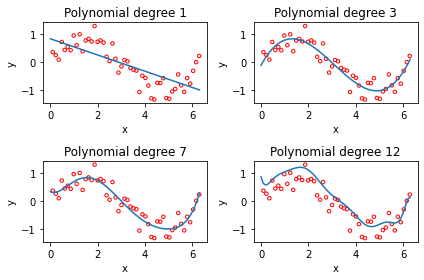

In [10]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [11]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    n_train = int(len(x) * ratio)
    train_ids = np.random.choice(len(x), n_train, replace=False)
    x_train = x[train_ids]
    y_train = y[train_ids]
    x_test = np.delete(x, train_ids)
    y_test = np.delete(y, train_ids)
    return x_train, y_train, x_test, y_test

Then, test your `split_data` function below.

In [12]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    tx_train = build_poly(x_train, degree)
    tx_test = build_poly(x_test, degree)
    w_ls, train_mse_ls = least_squares(y_train, tx_train)
    train_rmse_ls = compute_loss_rmse(y_train, tx_train, w_ls)
    test_rmse_ls = compute_loss_rmse(y_test, tx_test, w_ls)
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=train_rmse_ls, te=test_rmse_ls))

In [13]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

Condition number = 62.65772606371321
proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
Condition number = 515771.29633771797
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
Condition number = 250325212740442.12
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
Condition number = 1.1458953718814992e+24
proportion=0.9, degree=12, Training RMSE=6.386, Testing RMSE=6.288
Condition number = 51.93241678594001
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
Condition number = 330624.4703727426
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
Condition number = 124854767390624.19
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
Condition number = 9.477011822502194e+23
proportion=0.5, degree=12, Training RMSE=0.230, Testing RMSE=1.616
Condition number = 81.86568879420976
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
Condition number = 692059.3303906211
proportion=0.1, degree

# 3 Ridge Regression
Please fill in the function below.

In [14]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    mat = tx.T.dot(tx) + 2 * len(tx) * lambda_ * np.identity(tx.shape[1])
    c = np.linalg.cond(mat)
    print("Condition number = {}".format(c))
    w_rr = np.linalg.inv(mat).dot(tx.T).dot(y)
    return w_rr

In [15]:
from plots import plot_train_test

def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    tx_train = build_poly(x_train, degree)
    tx_test = build_poly(x_test, degree)
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        w_rr = ridge_regression(y_train, tx_train, lambda_)
        rmse_tr.append(compute_loss_rmse(y_train, tx_train, w_rr))
        rmse_te.append(compute_loss_rmse(y_test, tx_test, w_rr))
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Condition number = 766692782808327.4
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
Condition number = 363853132814927.6
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
Condition number = 165703989593366.12
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
Condition number = 73995363895688.08
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
Condition number = 32747600734206.137
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
Condition number = 14434911237623.914
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
Condition number = 6351523343596.346
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
Condition number = 2792554256025.7554
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
Condition number = 1227371454002.4866
proportion=0.5, degree

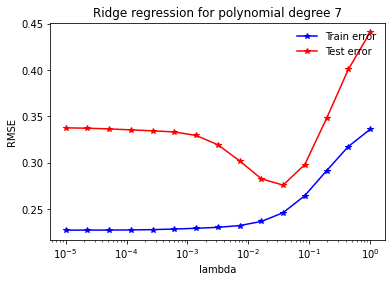

In [16]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)